# Modeling

## Introduction

### In the Preprocessing and Training notebook (<a href="https://github.com/trentleslie/Springboard/blob/main/16.3%20Capstone%20Two%20-%20Pre-processing%20and%20Training%20Data%20Development/3_preprocessing_and_training.ipynb">here</a>), models were evaluated for clarification efficiency at the recipe level and individual batch runs level. Using lazypredict, the two levels were evaluated with dropped NA values, NA values imputed with median values, and NA values imputed with mean values. 
###  Dropping NA values demonstrated the best performance by regression (R-squared and MAE) and by ExtraTreesRegressor (adjussted R-squared and RMSE) across all three approaches. With recipe level data, lazypredict found no useful models regardless of imputing method, presumably due to sample size. With batch level data, however, lazypredict found that tree models performed well enough for further evaluation.
### Specifically, the extra tree regressor performed the best, edging out random forest. In this notebook, the extra trees regressor will be further developed by evaluating feature selection.

## Imports

In [2]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_validate

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
import lazypredict
from lazypredict.Supervised import LazyRegressor

#from library.sb_utils import save_file

## Load Model

In [3]:
# This isn't exactly production-grade, but a quick check for development
# These checks can save some head-scratching in development when moving from
# one python environment to another, for example
expected_model_version = '1.0'
model_path = '../models/best_model.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    if model.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if model.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

## Load Data

In [6]:
batch_data = pd.read_csv('../data/processed/batch_data_clean_log.csv').drop('rcp_id', axis=1)
batch_data = batch_data.dropna()
batch_data.head()

,base_malt_pct_log,Boil Kettle_log,Whirlpool_log,Fermenter_log,Total Hops_log,fermenter_temperature_log,cu_low_log,cu_high_log,cu_setpoint_log,pre_run_dump_volume_log,original_gravity_log,clar_eff_log
91,0.47,0.79,0.22,0.54,0.76,0.02,-0.85,0.11,-0.71,0.89,0.37,-1.82
92,0.47,0.79,0.22,0.54,0.76,0.02,-0.85,0.11,-0.71,0.89,0.37,-1.82
93,0.47,0.79,0.22,0.54,0.76,-0.53,-0.15,-0.61,-0.71,0.87,0.37,-0.58
96,0.47,0.79,0.22,0.54,0.76,-0.29,0.11,-0.43,-0.71,0.77,0.37,-0.75
99,0.47,0.79,0.22,0.54,0.76,-0.11,-1.56,-1.33,-0.71,0.79,0.37,-1.44


## Refit Model On All Available Data

### I actually forgot to apply lazypredict on those imputed by the mean in the prior notebook (I have added it now though), so I'm going to check that for quick comparison. Since the original data was scaled and transformed, I don't expect this to make much of a difference. 

In [7]:
Xbatch_train, Xbatch_test, ybatch_train, ybatch_test = train_test_split(batch_data.drop(columns='clar_eff_log'), 
                                                    batch_data.clar_eff_log, test_size=0.3, 
                                                    random_state=47)

In [8]:
batch_tr = Xbatch_train
Xbatch_te = Xbatch_test

Xbatch_defaults_median = Xbatch_train.mean()

Xbatch_tr = Xbatch_train.fillna(Xbatch_defaults_median)
Xbatch_te = Xbatch_test.fillna(Xbatch_defaults_median)

reg_batch = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models_batch, predictions_batch = reg_batch.fit(Xbatch_tr, Xbatch_te, ybatch_train, ybatch_test)

print(models_batch)

 26%|██▌       | 11/42 [00:00<00:01, 28.55it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


 67%|██████▋   | 28/42 [00:01<00:00, 15.79it/s]

PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range for family PoissonDistribution


100%|██████████| 42/42 [00:02<00:00, 20.69it/s]

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
RandomForestRegressor                        0.59       0.63  0.61        0.21
ExtraTreesRegressor                          0.59       0.63  0.61        0.12
LGBMRegressor                                0.58       0.62  0.62        0.06
BaggingRegressor                             0.57       0.61  0.62        0.03
HistGradientBoostingRegressor                0.57       0.61  0.62        0.40
NuSVR                                        0.52       0.57  0.66        0.01
SVR                                          0.51       0.56  0.67        0.01
GradientBoostingRegressor                    0.51       0.56  0.67        0.05
MLPRegressor                                 0.47       0.52  0.70        0.38
AdaBoostRegressor                            0.46       0.51  0.70        0.08
XGBRegressor                                 0.42   

### As expected, these results are nearly identical to those imputed with median. In fact, the only difference in the extra trees regressor is an improvement of 0.02 in time taken. I'm going to stick to the original extra trees regressor (with dropped missing values) for easier comparison to feature selection work.


In [9]:
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(), 
    ExtraTreesRegressor()
)

pipe.fit(Xbatch_tr, ybatch_train)

y_tr_pred = pipe.predict(Xbatch_tr)
y_te_pred = pipe.predict(Xbatch_te)

#R-squared
print(f"R-squared: {r2_score(ybatch_train, y_tr_pred), r2_score(ybatch_test, y_te_pred)}")

#MAE
print(f"MAE: {mean_absolute_error(ybatch_train, y_tr_pred), mean_absolute_error(ybatch_test, y_te_pred)}")

#MSE
print(f"MSE: {mean_squared_error(ybatch_train, y_tr_pred), mean_squared_error(ybatch_test, y_te_pred)}")

cv_results = cross_validate(pipe, Xbatch_tr, ybatch_train, cv=5)
cv_scores = cv_results['test_score']
print(f"CV Scores: {cv_scores}")
print(f"CV Score Mean: {np.mean(cv_scores)}")
print(f"CV Score Std: {np.std(cv_scores)}")
print(f"CV Score 95% CI: {np.round((np.mean(cv_scores) - 2 * np.std(cv_scores), np.mean(cv_scores) + 2 * np.std(cv_scores)), 2)}")


R-squared: (1.0, 0.6035399279797817)
MAE: (1.0045739811604319e-15, 0.2929260922919227)
MSE: (1.9253993141852748e-30, 0.3995806815811044)
CV Scores: [0.30605415 0.568767   0.54466217 0.13686549 0.65948042]
CV Score Mean: 0.4431658453078879
CV Score Std: 0.19260772407607363
CV Score 95% CI: [0.06 0.83]


## Hyperparameter search using GridSearchCV (with Extra Trees Regressor)

R-squared: (1.0, 0.584508899318769)
MAE: (1.0045739811604319e-15, 0.32003450847398424)
MSE: (1.9253993141852748e-30, 0.418761506940913)
CV Scores: [0.34036851 0.58357814 0.55201092 0.10118979 0.64585898]
CV Score Mean: 0.4446012703796594
CV Score Std: 0.2000759774201196
CV Score 95% CI: [0.04 0.84]


Text(0.5, 1.0, 'Best extra trees regressor feature importances')

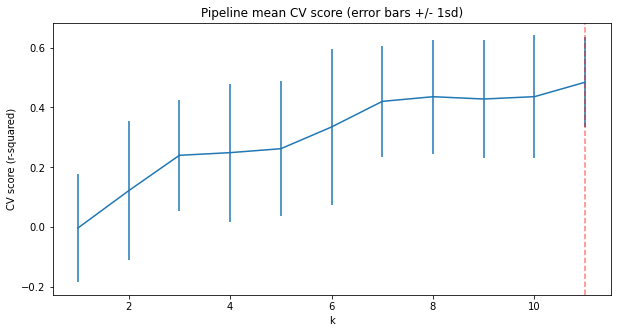

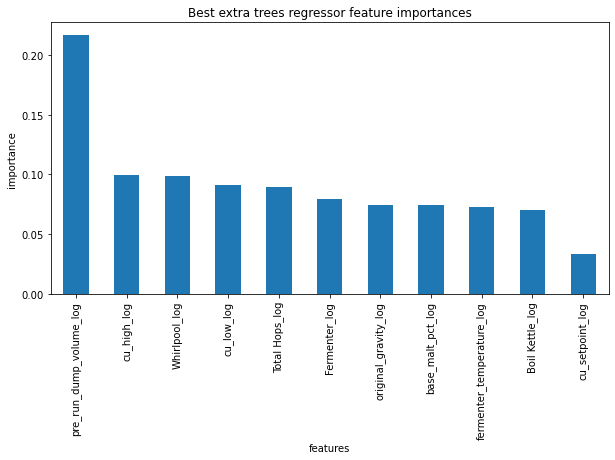

In [10]:
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(score_func=f_regression, k=8),
    ExtraTreesRegressor()
)

pipe.fit(Xbatch_tr, ybatch_train)

y_tr_pred = pipe.predict(Xbatch_tr)
y_te_pred = pipe.predict(Xbatch_te)

#R-squared
print(f"R-squared: {r2_score(ybatch_train, y_tr_pred), r2_score(ybatch_test, y_te_pred)}")

#MAE
print(f"MAE: {mean_absolute_error(ybatch_train, y_tr_pred), mean_absolute_error(ybatch_test, y_te_pred)}")

#MSE
print(f"MSE: {mean_squared_error(ybatch_train, y_tr_pred), mean_squared_error(ybatch_test, y_te_pred)}")

cv_results = cross_validate(pipe, Xbatch_tr, ybatch_train, cv=5)
cv_scores = cv_results['test_score']
print(f"CV Scores: {cv_scores}")
print(f"CV Score Mean: {np.mean(cv_scores)}")
print(f"CV Score Std: {np.std(cv_scores)}")
print(f"CV Score 95% CI: {np.round((np.mean(cv_scores) - 2 * np.std(cv_scores), np.mean(cv_scores) + 2 * np.std(cv_scores)), 2)}")

k = [k+1 for k in range(len(Xbatch_train.columns))]
grid_params = {'selectkbest__k': k}

etr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

etr_grid_cv.fit(Xbatch_train, ybatch_train)

score_mean = etr_grid_cv.cv_results_['mean_test_score']
score_std = etr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in etr_grid_cv.cv_results_['param_selectkbest__k']]

#Print the `best_params_` attribute of `lr_grid_cv`
etr_grid_cv.best_params_

#Assign the value of k from the above dict of `best_params_` and assign it to `best_k`
best_k = etr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)')

#Plot a barplot of the random forest's feature importances
plt.subplots(figsize=(10, 5))
imps = etr_grid_cv.best_estimator_.named_steps.extratreesregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=Xbatch_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best extra trees regressor feature importances')

## Feature Selection

### To make it more useful in practice, I am going to investigate a model without the features that we don't know prior to brew day. This would be removing pre_run_dump_volume_log, cu_high_log, and cu_low_log. Further, since total_hops_log is of lowest importance and derived from the other hop values, I will remove it as well.

In [11]:
Xbatch_tr = Xbatch_tr.drop(["pre_run_dump_volume_log", "cu_high_log", "cu_low_log", "Total Hops_log"], axis=1)
Xbatch_te = Xbatch_te.drop(["pre_run_dump_volume_log", "cu_high_log", "cu_low_log", "Total Hops_log"], axis=1)

print(Xbatch_tr.head())
print(Xbatch_te.head())


      base_malt_pct_log  Boil Kettle_log  Whirlpool_log  Fermenter_log  \
876               -1.24            -0.94          -1.74          -1.24   
108                0.47             0.79           0.22           0.54   
1108               0.43             2.44           1.72           2.60   
542               -1.71            -1.27          -1.74          -1.24   
277               -0.49            -0.48           0.37          -0.29   

      fermenter_temperature_log  cu_setpoint_log  original_gravity_log  
876                       -1.22             2.23                  1.38  
108                        1.12            -0.71                  0.37  
1108                       0.11             1.19                  1.73  
542                       -0.78            -0.71                 -1.48  
277                       -0.63            -0.71                 -0.03  
      base_malt_pct_log  Boil Kettle_log  Whirlpool_log  Fermenter_log  \
956               -0.22            -0.81   

R-squared: (0.9367905908248134, 0.5594795069915974)
MAE: (0.06275908230435664, 0.3719793394590622)
MSE: (0.05164000702715089, 0.4439879101816965)
CV Scores: [0.16528887 0.29287101 0.38492153 0.40353543 0.53825928]
CV Score Mean: 0.3569752266952476
CV Score Std: 0.12382711173927256
CV Score 95% CI: [0.11 0.6 ]


Text(0.5, 1.0, 'Best random forest regressor feature importances')

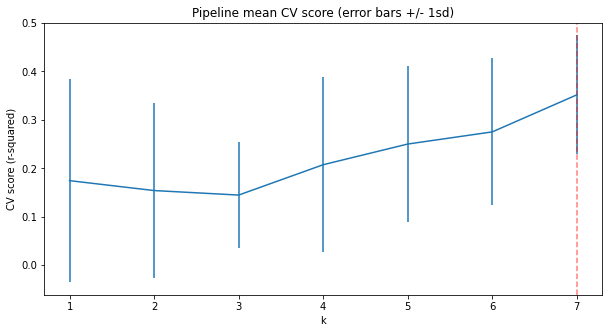

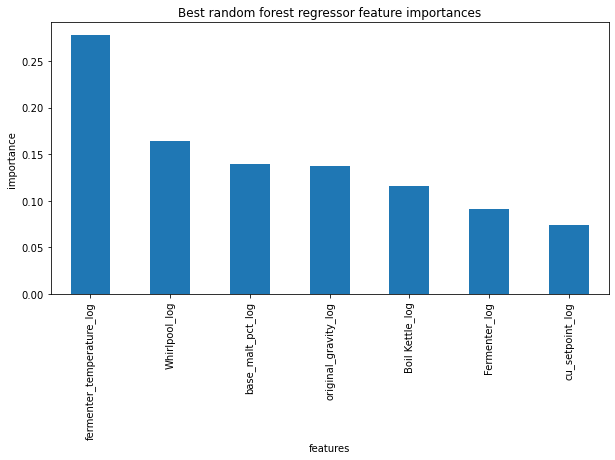

In [12]:
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(score_func=f_regression, k=7),
    ExtraTreesRegressor()
)

pipe.fit(Xbatch_tr, ybatch_train)

y_tr_pred = pipe.predict(Xbatch_tr)
y_te_pred = pipe.predict(Xbatch_te)

#R-squared
print(f"R-squared: {r2_score(ybatch_train, y_tr_pred), r2_score(ybatch_test, y_te_pred)}")

#MAE
print(f"MAE: {mean_absolute_error(ybatch_train, y_tr_pred), mean_absolute_error(ybatch_test, y_te_pred)}")

#MSE
print(f"MSE: {mean_squared_error(ybatch_train, y_tr_pred), mean_squared_error(ybatch_test, y_te_pred)}")

cv_results = cross_validate(pipe, Xbatch_tr, ybatch_train, cv=5)
cv_scores = cv_results['test_score']
print(f"CV Scores: {cv_scores}")
print(f"CV Score Mean: {np.mean(cv_scores)}")
print(f"CV Score Std: {np.std(cv_scores)}")
print(f"CV Score 95% CI: {np.round((np.mean(cv_scores) - 2 * np.std(cv_scores), np.mean(cv_scores) + 2 * np.std(cv_scores)), 2)}")

k = [k+1 for k in range(len(Xbatch_tr.columns))]
grid_params = {'selectkbest__k': k}

etr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

etr_grid_cv.fit(Xbatch_tr, ybatch_train)

score_mean = etr_grid_cv.cv_results_['mean_test_score']
score_std = etr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in etr_grid_cv.cv_results_['param_selectkbest__k']]

#Print the `best_params_` attribute of `lr_grid_cv`
etr_grid_cv.best_params_

#Assign the value of k from the above dict of `best_params_` and assign it to `best_k`
best_k = etr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)')

#Plot a barplot of the random forest's feature importances
plt.subplots(figsize=(10, 5))
imps = etr_grid_cv.best_estimator_.named_steps.extratreesregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=Xbatch_tr.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances')

### There is definitely a cost with removing features, but most of the cost is on the training data prediction. The performance on the test data was impacted, but not nearly as much as the training data. This suggests the dropped features were resulting in the regressor training to the training data and not necessarily performing much better on unseen data. Regardless of any shortcomings with the model of fewer features, the extra trees regressor is the best model for this data.